In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
import seaborn as sns
import os
from copy import deepcopy
%matplotlib inline
#sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
#sns.set(font_scale=0.5)
#plt.rcParams['font.family'] = 'arial.ttf'
#sns.set(font='arial.ttf')

from sklearn.ensemble import RandomForestRegressor
import random
import math
import scipy.stats as stats
import scipy.signal
from scipy.stats import spearmanr, pearsonr
from sklearn import preprocessing
from tqdm import tqdm, trange
import pickle
from itertools import product
from collections import OrderedDict
import torch
import torch.nn.functional as F
seed = 1337
random.seed(seed)
np.random.seed(seed)
import matplotlib as mpl
import matplotlib
import torch.nn as nn

In [2]:
import argparse
from argparse import Namespace
from collections import Counter
parser = argparse.ArgumentParser()

parser.add_argument('--filename', type = str, default = './ESM2_finetuned/attentions_symm//UTR-LM/Sample/Embedding_Contacts/ESM2_finetuned/representations_bos/Finetuned_VaryLengthHumanAll_sequence__MJ7_seed1337_ESM2SISS_FS4.1.Independent.len100.1e-2.dr5_VaryLengthRandomTrain_sequence_utr__representations_bos.npz')
parser.add_argument('--ngrams', type = int, default = 8)
parser.add_argument('--ratio', action = 'store_true')
args = parser.parse_args([])
print(args)

global obj_col, seed
out_filename = f'SHAP_{args.ngrams}grams__' + '__'.join(args.filename.split('__')[1:3])
print(out_filename)

Namespace(filename='./ESM2_finetuned/attentions_symm//UTR-LM/Sample/Embedding_Contacts/ESM2_finetuned/representations_bos/Finetuned_VaryLengthHumanAll_sequence__MJ7_seed1337_ESM2SISS_FS4.1.Independent.len100.1e-2.dr5_VaryLengthRandomTrain_sequence_utr__representations_bos.npz', ngrams=8, ratio=False)
SHAP_8grams__MJ7_seed1337_ESM2SISS_FS4.1.Independent.len100.1e-2.dr5_VaryLengthRandomTrain_sequence_utr__representations_bos.npz


In [3]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def performances(label, pred):
    
    r = r2(label, pred)
    pearson_r = pearsonr(label, pred)[0]
    sp_cor = spearmanr(label, pred)[0]
    print(f'r-squared = {r:.4f} | pearson r = {pearson_r:.4f} | spearman R = {sp_cor:.4f}')
            
    return [r, pearson_r, sp_cor]

In [4]:
def kmers_list(ngrams = 3):
    kmers = list('AGCT')
    for i in trange(1, ngrams):
        kmers = [''.join(c) for c in list(product(kmers, 'AGCT'))]
        print(f'{i+1}-mers: {len(kmers)}')
    return kmers

In [5]:
def generate_seqs_kmers_contacts_pd(data, kmers):
    seqs_kmers_contacts_pd = pd.DataFrame()
    i = 0
    for seq, attention_contacts in tqdm(zip(data['sequences'], data[obj_col])):
        seq = seq.replace('<pad>', '')
        attention_contacts = attention_contacts[:len(seq), :len(seq)]

        if args.ratio:
            attention_contrib_ratio = F.softmax(torch.Tensor(attention_contacts), dim = 0) # 列相加=1
            seq_contrib_ratio = np.array(attention_contrib_ratio.sum(axis = 1))

            temp_dict = create_ngram_list(seq, len(kmers[0]), seq_contrib_ratio, kmers)
        else:
            seq_contact_scores = attention_contacts.sum(axis = 1)

            temp_dict = create_ngram_list(seq, len(kmers[0]), seq_contact_scores, kmers)

        if i == 0: 
            seq_kmers_dict = deepcopy(temp_dict)
            i += 1
        else:
            seq_kmers_dict = dict(Counter(seq_kmers_dict) + Counter(temp_dict))
    
    return seq_kmers_dict

In [6]:
def create_ngram_list(seq, ngrams, contact_scores, kmers_list):
    kmers_dict = OrderedDict(zip(kmers_list, [0]*len(kmers_list)))
    
    if len(seq) >= ngrams:
        mer = zip(*[seq[i:] for i in range(ngrams)])
        con = zip(*[contact_scores[i:] for i in range(ngrams)])
        for m, c in zip(mer, con):
            tmp = ''.join(m)
            kmers_dict.setdefault(tmp, 0)
            kmers_dict[tmp] += sum(c)
            
    return kmers_dict

In [7]:
def generate_subset(a):
    subset = []
    for i in range(len(a)+1):
        for j in range(1, len(a)+1):
            if j > i: 
                temp = a[i:j]
                if temp != a:
                    subset.append(temp)
    return subset

# NucType-Position

In [8]:
def attn_HLA_length_aatype_position_num(data, attn_data, hla = 'HLA-A*11:01', label = None, length = 9, show_num = False):
    aatype_position = dict()
    if label == None:
        length_index = np.array(data[data.length == length][data.HLA == hla].index)
    else:
        length_index = np.array(data[data.length == length][data.HLA == hla][data.label == label].index)

    length_data_num = len(length_index)

    for head in range(9):
        for idx in length_index:
            temp_peptide = data.iloc[idx].peptide
            temp_length_head = deepcopy(nn.Softmax(dim=-1)(attn_data[idx][head][:, :length].float())) # Shape = (34, 9), 行是HLA，列是peptide，由行查列
            temp_length_head = nn.Softmax(dim=-1)(temp_length_head.sum(axis = 0)) # 把这一列的数据相加，shape = （9，）

            for i, aa in enumerate(temp_peptide): 
                aatype_position.setdefault(aa, {})
                aatype_position[aa].setdefault(i, 0)
                aatype_position[aa][i] += temp_length_head[i] 
    
    if show_num:
        aatype_position_num = dict()
        for idx in length_index:
            temp_peptide = data.iloc[idx].peptide
            for i, aa in enumerate(temp_peptide):
                aatype_position_num.setdefault(aa, {})
                aatype_position_num[aa].setdefault(i, 0)
                aatype_position_num[aa][i] += 1
             
        return aatype_position, aatype_position_num
    else:
        return aatype_position


In [17]:

def nuctype_position_pd(seqs, attn, l = 100):
    nuctype_position = dict()
    attn_nuctype_position = deepcopy(torch.Tensor(attn))
    attn_nuctype_position = nn.Softmax(dim = -1)(attn_nuctype_position) # 对每个instance取由行查列的attn归一化
    attn_nuctype_position = attn_nuctype_position.sum(dim = 1) # 对每个instance的列相加
    print(attn_nuctype_position.shape)
    for s_i, seq in tqdm(enumerate(seqs)):
        for n_i, nuc in enumerate(seq):
            nuctype_position.setdefault(nuc, {})
            nuctype_position[nuc].setdefault(n_i, 0)
            nuctype_position[nuc][n_i] += attn_nuctype_position[s_i][n_i]


    nuctype_position_pd = np.zeros((4, l))
    #########
    nuc_i, nuc_indexs = 0, []
    for nuc, nuc_posi in tqdm(nuctype_position.items()):
        nuc_indexs.append(nuc)
        for posi, v in nuc_posi.items():
            nuctype_position_pd[nuc_i, posi] = v
        nuc_i += 1

    nuctype_position_pd_unsoftmax = pd.DataFrame(nuctype_position_pd, index = nuc_indexs, columns = range(1, l+1))

    nuctype_position_pd_softmax = deepcopy(nn.Softmax(dim = -1)(torch.Tensor(nuctype_position_pd)))
    nuctype_position_pd_softmax = pd.DataFrame(nuctype_position_pd_softmax, index = nuc_indexs, columns = range(1, l+1))        
    #########
    attn_position = deepcopy(torch.Tensor(attn))
    attn_position = nn.Softmax(dim = -1)(attn_position) # 对每个instance取由行查列的attn归一化
    attn_position = attn_position.sum(dim = 0) # 对所有instance的attn相加
    attn_position = np.array((attn_position.sum(axis = 0)))# 把这一列的数据相加
    print(attn_position.shape)
    return nuctype_position_pd_unsoftmax.loc[['A','G','C','T']], nuctype_position_pd_softmax.loc[['A','G','C','T']], attn_position

In [18]:
def draw_nuctype_position(nuctype_position_pd_unsoftmax, nuctype_position_pd_softmax, n, l = 100, outputfile = ''):
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 6))
    cmap = 'YlGn'
    sns.heatmap(nuctype_position_pd_unsoftmax, xticklabels = range(l, 0, -1),
#                 ax = axes[0], 
                cmap = cmap, square = True, cbar = False)
    norm_unsoftmax = mpl.colors.Normalize(vmin = nuctype_position_pd_unsoftmax.values.min()/n,
                                        vmax = 1.7)#nuctype_position_pd_unsoftmax.values.max()/n)
    cbar_unsoftmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_unsoftmax, cmap = cmap),
                                orientation = 'vertical', shrink = 0.2)#, ax = axes[0])
    cbar_unsoftmax.outline.set_visible(False)
    
    plt.title('Human (n=15,555): NucType - Position')


#     sns.heatmap(nuctype_position_pd_softmax, xticklabels = range(50, 0, -1),
#                 ax = axes[1], cmap = cmap, square = True, cbar = False)
#     print(len(nuctype_position_pd_softmax))
#     norm_softmax = mpl.colors.Normalize(vmin = nuctype_position_pd_softmax.values.min()/n,
#                                         vmax = nuctype_position_pd_softmax.values.max()/n)
#     cbar_softmax = fig.colorbar(mpl.cm.ScalarMappable(norm = norm_softmax, cmap = cmap),
#                                 orientation = 'vertical', ax = axes[1])
#     cbar_softmax.outline.set_visible(False)
#     axes[1].set_title('Unmod_1 (n=280000): NucType - Position | Softmax Normalization')
    plt.savefig(outputfile, dpi = 300)
#     plt.show()
    
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
def draw_position_attention(attn_position, n, l = 100):
    fig = plt.figure()

    cmap = 'OrRd'
    sns.heatmap(attn_position.reshape(-1, 1).T, cmap = cmap, cbar = False, square = True,
            xticklabels = range(l, 0, -1), yticklabels = '')

    plt.title('Human (n=15,555) | Positional Attention')
    plt.xlabel("5'UTR position")
    plt.ylabel('')

    norm = mpl.colors.Normalize(vmin = min(attn_position)/n, vmax = max(attn_position)/n)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                    orientation='vertical', shrink = 0.5) # , anchor = (-0.2, 0.5)
    cbar.outline.set_visible(False)

    plt.show()

In [19]:
def obtained_low_high_label(seqs, labels, attns, low=2, high=10):
    """
    Get the indices of elements in the 'labels' array that fall within the range [low, high].

    Parameters:
    labels (numpy.ndarray): NumPy array of labels.
    low (int): Lower bound of the range (inclusive).
    high (int): Upper bound of the range (inclusive).

    Returns:
    low_indices (numpy.ndarray): Indices of elements in 'labels' that are greater than or equal to 'low'.
    high_indices (numpy.ndarray): Indices of elements in 'labels' that are less than or equal to 'high'.
    """
    low_indices = np.where((labels < low))[0]
    high_indices = np.where(labels > high)[0]
    return (seqs[low_indices], labels[low_indices], attns[low_indices]), (seqs[high_indices], labels[high_indices], attns[high_indices])


# Finetuned

In [20]:
plt.rcParams.update({'font.size': 7})

In [21]:
obj_col = 'attentions_symm_ESM2'
pwd = '/scratch/users/yanyichu/UTR-LM/Independent/Embedding_Contacts/ESM2_finetuned/attentions_symm/'
filename = 'Finetuned_VaryLengthHumanAll_sequence__MJ7_seed1337_ESM2SISS_FS4.1.Independent.len100.1e-2.dr5_VaryLengthRandomTrain_sequence_utr__attentions_symm.npz'

data = np.load(pwd + filename)
print(list(data.keys()))

attns = data[obj_col]
seqs = data['sequences']
labels = data['labels']
print(attns.shape, len(seqs))

index_nondup = np.array(pd.DataFrame(seqs).drop_duplicates().index)
seqs = seqs[index_nondup]
seqs = np.array([s.replace('<pad>', 'N') for s in seqs])
labels = labels[index_nondup]
attns = attns[index_nondup]
print(attns.shape, len(seqs))

['sequences', 'labels', 'attentions_symm_ESM2']
(15555, 100, 100) 15555
(15555, 100, 100) 15555


In [23]:
seqs

array(['TCCCCACTCCCCTTTCCCTGCCCAC', 'ATCTCCAGCCTTACCGCGGCTCGAA',
       'CACTTCGGAGGATTGCTCAACAACC', ...,
       'ACCGAGCCGAGAGGACCCGAGTGGGGCCGAGGCCAGTAGCCCCGGGGCCCTGAGCAGAGGCCGTAGCTTGCGCCGCACCCGCGGCCAGGCGGAGCCAAAG',
       'ATGTTGTGATGGAGAAGCCGCGGCGGAGCCCGAACCCCGCAGCCTGAGCCACCTCCGTCATCTGGGCCCGGGGCCTCACCGCGCAGGAGCTGCCAAGGCC',
       'AGGAGGAGAAAGCTGACCGCTTAGGCCGGGGTAGTGGTCGTCGTGGTTTTCCTTGTAGTTCGTGGTCTGAGACCAGGCCTCAAGTGGAAACGGCGTCACC'],
      dtype='<U100')

In [24]:
labels

array([4.57901529, 5.61433154, 5.98611951, ..., 7.53956911, 3.74095155,
       5.58595158])

# ATG

In [25]:
# 导入需要的库
import random

# 生成示例的UTR序列列表（这里假设有100个序列，每个序列长度在25到100之间）
#  = [''.join(random.choice('ACGT') for _ in range(random.randint(25, 100))) for _ in range(100)]

def stat_atg_num(utr_sequences):
    # 初始化统计变量
    total_sequences_with_atg = 0
    total_atg_count = 0
    position_counts = [0] * 100
    atg_num_list = []
    # 遍历每个UTR序列
    for sequence in utr_sequences:
        # 统计出现ATG的序列数量
        if 'ATG' in sequence:
            total_sequences_with_atg += 1

            # 统计每个序列中ATG的出现次数
            atg_count = sequence.count('ATG')
            total_atg_count += atg_count

            # 统计ATG在不同位置上的出现次数
            for i in range(len(sequence) - 2):  # 减去2是因为要避免序列末尾的位置
                if sequence[i:i + 3] == 'ATG':
                    position_counts[i] += 1
                    
            atg_num_list.append(atg_count)
        else:
            atg_num_list.append(0)
    # 计算平均每个序列出现ATG的次数
    average_atg_count_per_sequence = total_atg_count / total_sequences_with_atg

    # 打印统计结果
    print(f"出现ATG的序列数量: {total_sequences_with_atg}")
    print(f"出现ATG的数量: {total_atg_count}")
    print(f"平均每个序列出现ATG的次数: {average_atg_count_per_sequence}")
#     print("ATG在不同位置上的出现次数:")
#     for i, count in enumerate(position_counts):
#         print(f"位置 {i+1} 出现次数: {count}")
    return np.array(position_counts).T, atg_num_list

In [177]:
sorted_indices = np.argsort(labels)

# 使用索引对数组进行排序
sorted_labels = labels[sorted_indices]
sorted_seqs = seqs[sorted_indices]
sorted_attns = attns[sorted_indices]
print("Sorted Array:", sorted_labels)
print("Indices of Sorted Array:", sorted_indices)


Sorted Array: [ 0.79257236  1.09902955  1.30373552 ...  9.5220938   9.7336731
 10.19528271]
Indices of Sorted Array: [ 9808 13219 11035 ... 14958 14433  8280]


In [178]:
high_156 = pd.DataFrame([sorted_seqs[-156:], sorted_labels[-156:]], index = ['Sequences', 'MRL']).T
high_156 = high_156.sort_values('MRL', ascending = False).reset_index(drop = True)

low_156 = pd.DataFrame([sorted_seqs[:156], sorted_labels[:156]], index = ['Sequences', 'MRL']).T
low_156 = low_156.sort_values('MRL', ascending = False).reset_index(drop = True)

high_100 = pd.DataFrame([sorted_seqs[-100:], sorted_labels[-100:]], index = ['Sequences', 'MRL']).T
high_100 = high_100.sort_values('MRL', ascending = False).reset_index(drop = True)

low_100 = pd.DataFrame([sorted_seqs[:100], sorted_labels[:100]], index = ['Sequences', 'MRL']).T

In [209]:
'''
15555 seqs
'''
seqs_atg, seqs_atg_nums = stat_atg_num(seqs)

出现ATG的序列数量: 3714
出现ATG的数量: 4981
平均每个序列出现ATG的次数: 1.3411416262789446


In [179]:
print('Lowest 100:')
low100_atg, low100_atg_nums = stat_atg_num(low_100.Sequences)
print('\nHighest 100:')
high100_atg, high100_atg_nums = stat_atg_num(high_100.Sequences)
print('\nLowest 10% (n=156):')
low156_atg, low156_atg_nums = stat_atg_num(low_156.Sequences)
print('\nHighest 10% (n=156):')
high156_atg, high156_atg_nums = stat_atg_num(high_156.Sequences)

Lowest 100:
出现ATG的序列数量: 98
出现ATG的数量: 164
平均每个序列出现ATG的次数: 1.6734693877551021

Highest 100:
出现ATG的序列数量: 8
出现ATG的数量: 8
平均每个序列出现ATG的次数: 1.0

Lowest 10% (n=156):
出现ATG的序列数量: 147
出现ATG的数量: 228
平均每个序列出现ATG的次数: 1.5510204081632653

Highest 10% (n=156):
出现ATG的序列数量: 11
出现ATG的数量: 11
平均每个序列出现ATG的次数: 1.0


In [180]:
low_100['ATG_Count'] = low100_atg_nums
low_100.to_csv('Human_Low100MRL.csv')

high_100['ATG_Count'] = high100_atg_nums
high_100.to_csv('Human_High100MRL.csv')

high_156['ATG_Count'] = high156_atg_nums
high_156.to_csv('Human_High156MRL.csv')

low_156['ATG_Count'] = low156_atg_nums
low_156.to_csv('Human_Low156MRL.csv')

In [239]:
low_100.head()

,Sequences,MRL,ATG_Count
0,AGGATGCCCTGCGCGGGGCGGCGGAGCGGGTGCGTGCGGCGGCGGT...,0.792572,2
1,AGACAGAGGGGGCACAGTGCGAGGCTGCAGGGCAGGATGACCTAAC...,1.09903,2
2,GCTCGGCGAACATGGCGGCGGCGACGGTCGGGCGGGACACTTTACC...,1.303736,1
3,AAATGTAGTCACTGTCCCGGAACCTGGGGCAGCGGAGTCCCGTGCG...,1.322791,1
4,ATATATCCGTAGGAATGGAGAGGGACCGGATCTCAGGGCATGGCTC...,1.330691,2


In [181]:
stats.ttest_ind(low100_atg_nums, high100_atg_nums)

Ttest_indResult(statistic=15.975563967127938, pvalue=1.8684130815812568e-37)

In [182]:
stats.ttest_ind(low156_atg_nums, high156_atg_nums)

Ttest_indResult(statistic=18.61687190841428, pvalue=1.879651434421103e-52)

In [189]:
pearsonr(low_100.MRL, low_100.ATG_Count), \
pearsonr(high_100.MRL, high_100.ATG_Count), \
pearsonr(low_156.MRL, low_156.ATG_Count), \
pearsonr(high_156.MRL, high_156.ATG_Count)

(PearsonRResult(statistic=0.025862820082121252, pvalue=0.7983992490313356),
 PearsonRResult(statistic=-0.052467387880056726, pvalue=0.6041549865170118),
 PearsonRResult(statistic=-0.16850095727165632, pvalue=0.035491204008331285),
 PearsonRResult(statistic=-0.007020558732788815, pvalue=0.9306853447508061))

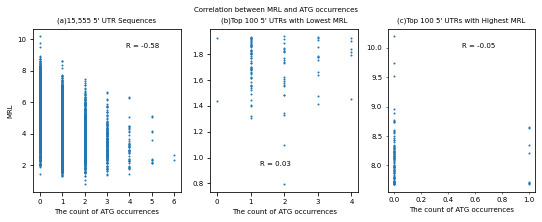

In [255]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr

# 创建颜色映射，根据序列长度映射颜色
colors = np.array([len(s) for s in seqs])
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3))
# 绘制散点图
axes[0].scatter(seqs_atg_nums, labels, s = 1)#, c=colors, cmap='viridis', marker='o', s = 1)
axes[0].set_title("(a)15,555 5' UTR Sequences", fontsize=7)

axes[1].scatter(low_100.ATG_Count, low_100.MRL, s = 1)#, c=colors, cmap='viridis', marker='o', s = 1)
axes[1].set_title("(b)Top 100 5' UTRs with Lowest MRL", fontsize=7)

axes[2].scatter(high_100.ATG_Count, high_100.MRL, s = 1)#, c=colors, cmap='viridis', marker='o', s = 1)
axes[2].set_title("(c)Top 100 5' UTRs with Highest MRL", fontsize=7)
# 设置横纵坐标标签
axes[0].set_ylabel('MRL', fontsize=7)
axes[0].set_xlabel('The count of ATG occurrences', fontsize=7)
axes[1].set_xlabel('The count of ATG occurrences', fontsize=7)
axes[2].set_xlabel('The count of ATG occurrences', fontsize=7)
plt.tick_params(axis='both', which='both', width=0.5, length=2, labelsize=7)

# 设置坐标轴的字号为7pt
# plt.xticks(range(0, 1022, 100), fontsize=7)
# plt.yticks(range(-700, 1, 100), fontsize=7)

# 添加标题
plt.suptitle("Correlation between MRL and ATG occurrences", fontsize=7)

# 计算 Spearman R、Pearson R 和 R2
all_pearson, _ = pearsonr(seqs_atg_nums, labels)
low100_pearson, _ = pearsonr(low_100.ATG_Count, low_100.MRL)
high100_pearson, _ = pearsonr(high_100.ATG_Count, high_100.MRL)

# 将计算结果添加到图中
# text = f'R-Squared = {r_squared:.2f}\nSpearman R = {spearman_corr:.2f}\nPearson R = {pearson_corr:.2f}'
# print(text)
all_pearson = f'R = {all_pearson:.2f}'
low_pearson = f'R = {low100_pearson:.2f}'
high_pearson = f'R = {high100_pearson:.2f}'

plt.text(-2, 10, all_pearson, fontsize=7)
plt.text(-1, 8, low_pearson, fontsize=7)
plt.text(0.5, 10, high_pearson, fontsize=7)
# 显示图形
# plt.savefig('/scratch/users/yanyichu/UTR-LM/MJ_FiveSpecies_MFE_length.jpg', dpi = 300)
plt.show()

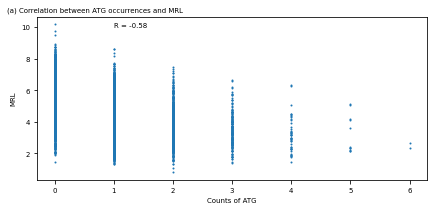

In [320]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr

# 创建颜色映射，根据序列长度映射颜色
colors = np.array([len(s) for s in seqs])
plt.figure(figsize = (7,3))
# 绘制散点图
plt.scatter(seqs_atg_nums, labels, s = 1)#, c=colors, cmap='viridis', marker='o', s = 1)
# plt.title("(a)Correlation between MRL and ATG occurrences across 15,555 5' UTR Sequences", fontsize=7)

# axes[1].scatter(low_100.ATG_Count, low_100.MRL, s = 1)#, c=colors, cmap='viridis', marker='o', s = 1)
# axes[1].set_title("(b)Top 100 5' UTRs with Lowest MRL", fontsize=7)

# axes[2].scatter(high_100.ATG_Count, high_100.MRL, s = 1)#, c=colors, cmap='viridis', marker='o', s = 1)
# axes[2].set_title("(c)Top 100 5' UTRs with Highest MRL", fontsize=7)
# # 设置横纵坐标标签
plt.ylabel('MRL', fontsize=7)
plt.xlabel('Counts of ATG', fontsize=7)
# axes[1].set_xlabel('The count of ATG occurrences', fontsize=7)
# axes[2].set_xlabel('The count of ATG occurrences', fontsize=7)
# plt.tick_params(axis='both', which='both', width=0.5, length=2, labelsize=7)

# 设置坐标轴的字号为7pt
# plt.xticks(range(0, 1022, 100), fontsize=7)
# plt.yticks(range(-700, 1, 100), fontsize=7)

# 添加标题
# plt.suptitle("Correlation between MRL and ATG occurrences", fontsize=7)

# 计算 Spearman R、Pearson R 和 R2
all_pearson, _ = pearsonr(seqs_atg_nums, labels)
# low100_pearson, _ = pearsonr(low_100.ATG_Count, low_100.MRL)
# high100_pearson, _ = pearsonr(high_100.ATG_Count, high_100.MRL)

# 将计算结果添加到图中
# text = f'R-Squared = {r_squared:.2f}\nSpearman R = {spearman_corr:.2f}\nPearson R = {pearson_corr:.2f}'
# print(text)
all_pearson = f'R = {all_pearson:.2f}'
# low_pearson = f'R = {low100_pearson:.2f}'
# high_pearson = f'R = {high100_pearson:.2f}'

plt.text(1, 10, all_pearson, fontsize=7)
plt.text(-0.8, 11, "(a) Correlation between ATG occurrences and MRL", fontsize=7)
# plt.text(-1, 8, low_pearson, fontsize=7)
# plt.text(0.5, 10, high_pearson, fontsize=7)
# 显示图形
plt.savefig('/scratch/users/yanyichu/UTR-LM/MJ_Correlation_MRL_ATGnum.pdf', dpi = 300)
plt.show()

/tmp/ipykernel_125633/1915159178.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


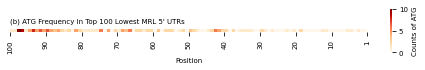

In [321]:
fig = plt.figure(figsize = (8, 10))

cmap = 'OrRd'
sns.heatmap(np.array(low100_atg).reshape(-1, 100), cmap = cmap, cbar = False, square = True,
        xticklabels = range(100,0,-10), yticklabels = '')

xtick_positions = range(100, -1, -10)  # 每10个位置一个xtick
plt.xticks(xtick_positions, [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('Position')

plt.title(f"(b) ATG Frequency in Top 100 Lowest MRL 5' UTRs", loc = 'left', fontsize=7)
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = low100_atg.min(), vmax = low100_atg.max()+1)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                orientation='vertical', shrink = 0.08) # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)
cbar.set_label('Counts of ATG', fontsize=7)

plt.savefig(f'/scratch/users/yanyichu/UTR-LM/MRL_Top100Lowest_ATG_Frequency.pdf')
plt.show()
#     break

/tmp/ipykernel_125633/3148392117.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


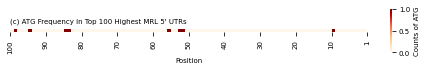

In [322]:
fig = plt.figure(figsize = (8, 10))

cmap = 'OrRd'
sns.heatmap(np.array(high100_atg).reshape(-1, 100), cmap = cmap, cbar = False, square = True,
        xticklabels = range(100,0,-10), yticklabels = '')

xtick_positions = range(100, -1, -10)  # 每10个位置一个xtick
plt.xticks(xtick_positions, [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
# plt.xtickslabel(range(100, 0, -10), range(100, 0, -10))

plt.title(f"(c) ATG Frequency in Top 100 Highest MRL 5' UTRs", loc = 'left', fontsize=7)
plt.ylabel('')
plt.xlabel('Position')

norm = mpl.colors.Normalize(vmin = high100_atg.min(), vmax = high100_atg.max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                orientation='vertical', shrink = 0.08) # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)
cbar.set_label('Counts of ATG', fontsize=7)

plt.savefig(f'/scratch/users/yanyichu/UTR-LM/MRL_Top100Highest_ATG_Frequency.pdf')
plt.show()
#     break

# Example of Low and High

In [14]:
(seqs_low, labels_low, attns_low), (seqs_high, labels_high, attns_high) = obtained_low_high_label(seqs, labels, attns, low=3, high=8)
seqs_low.shape, seqs_high.shape

((878,), (58,))

In [87]:
index_ccacc_high = []
for i,( s, l) in enumerate(zip(seqs, labels)):
    if 'CCACC' in s[-6:] and l > 6:
        index_ccacc_high.append([i, s, l])

index_ccacc_low = []
for i,( s, l) in enumerate(zip(seqs, labels)):
    if 'CCACC' in s and 'CCACC' not in s[-6:] and l < 2:
        index_ccacc_low.append([i, s, l])
index_ccacc_high

[[477, 'TTCTGATTTCAGCTCTCAGCATCCACC', 6.03138523484],
 [1018, 'GGGTCAGTTCCTGCTACAGCTATCCCACC', 6.09661360699],
 [1418, 'TTGGGTCAGTTCCTGCTACAGCTATCCCACC', 6.21369977674],
 [1671, 'GTCAGTCGTGAAGAGGGAGCTCTATTGCCACC', 6.125911909],
 [2513, 'AGAGGGAGCAGTGAATAGCAATAGGGTGTTTCCACC', 6.0692334925],
 [2743, 'GAGAGACTGAAGAACCCAGCATTGCAGCAGCTCCACC', 6.23050785518],
 [2775, 'ACTCTTCTGGTCCCCACAGACTCAGAGAGAACCCACC', 6.0652515473],
 [2960, 'GCTGCTGTTTCCTTCGGCTTTCCTCCTCCTGCTCCACC', 6.07061318328],
 [3164, 'CTGCTTTTCTCCAGCTCTGTCAACTCAACCTTTCCCACC', 6.16877985996],
 [3207, 'GTGCCTGGGCTTGCTCATTCAGTCACAGTCACAGCCACC', 6.11214477234],
 [4132, 'GAGGGCTTGGGAGAGCAAGCCGCGGAGAGAACTTGAAGCCACC', 6.41749108873],
 [4258, 'GCATCCCCTGCGCGAAGCTGGGTGCCCCGGAGAGTCTGACCACC', 6.22775212786],
 [4512, 'GCTCTCAGAGGCAGCGTGCGGGTGTGCTCTTTGTGAAATTCCACC', 6.26224976185],
 [4539, 'TTACTTTCTTACTCTTGGGTCAGTTCCTGCTACAGCTATCCCACC', 6.2200897682],
 [4666, 'GCCGAAGGTGCCTGGGCTTGCTCATTCAGTCACAGTCACAGCCACC', 6.11567289109],
 [4687, 'CTTTGAAGC

In [88]:
index_atg_high = []
for i,( s, l) in enumerate(zip(seqs, labels)):
    if 'ATG' not in s and l > 9:
        index_atg_high.append([i, s, l])

index_atg_low = []
for i,( s, l) in enumerate(zip(seqs, labels)):
    if 'ATG' in s and l < 1.5:
        index_atg_low.append([i, s, l])
index_atg_low

[[8677,
  'CTCCAGGAATGGGTTTGAAGCCGTGGAGGCAGAGGGCAGCGCAGGGTGCCGGGGAAGCTCGGGA',
  1.44673042608],
 [9808,
  'AGGATGCCCTGCGCGGGGCGGCGGAGCGGGTGCGTGCGGCGGCGGTTGCGAGAGAGATGAGCCGCGGCG',
  0.792572364595],
 [10009,
  'GCCTGTCACCATGTAAGAAGTGAATTTGCTCCTCGTTCGCCTTCTGCCATGATTGTGAGGCCTCTCCAGCC',
  1.4869998283],
 [11035,
  'GCTCGGCGAACATGGCGGCGGCGACGGTCGGGCGGGACACTTTACCTGAGCATTGGTCCTACGGGGTGTGCCGGG',
  1.30373552398],
 [11297,
  'GGCTCCTCTTCCCTTCTGTAGACCCTTCTCTGTCTTCTTTTACCTTGCAGGATGTGAGGGCAGGCCCCCAGCCCCTC',
  1.40957206335],
 [11799,
  'GTCTGTATCAGACATCATGGGAGCAGATCCAGGGCGACATCAAAGGGAAGCATGAGTCTCCAGGACCAGAGGGGCTTGG',
  1.48713070327],
 [11807,
  'CTTCTTCCCGGGGCTCTTCGCGCTCTGCACCTGGGCGCTGCGCCGCTCCCAGCCCGGATGGAGCCGCACCGACTGCGTG',
  1.49517203059],
 [12024,
  'GTGCGTCACAGAATGGCCTCGGACACCCAGGCAGTCCCTGACGTGTCGGGGAGGAGCCGGGCGCGGAGGCTTTCTTGATC',
  1.40015620396],
 [12057,
  'AGTTGGTAAATGACAGTTATGAATAAAGCAAGGGCAGAAAAAAACATGTAGGGGAGAGAATGAGGAACTAGGTCCAGGAG',
  1.45540965233],
 [13219,
  'AGACAGAGGGGGCACAGTG

/tmp/ipykernel_125633/2752093334.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


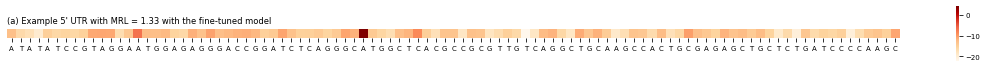

In [105]:
# for (i, s, l) in index_atg_low:
#     print(i, s, f'{l:.2f}')
i = 15377
s, l, a = seqs[i], labels[i], attns[i]
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
fig = plt.figure(figsize = (20, 10))

cmap = 'OrRd'
sns.heatmap(a.sum(axis = -1).reshape(-1, 1).T[:, -len(s):], cmap = cmap, cbar = False, square = True,
        xticklabels = s, yticklabels = '')

plt.title(f"(a) Example 5' UTR with MRL = {l:.2f} with the fine-tuned model", loc = 'left')
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = a.min().min(), vmax = a.max().max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                orientation='vertical', shrink = 0.1) # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)

plt.savefig(f'MRL{l:.2f}_finetuned.pdf')
plt.show()
#     break

/tmp/ipykernel_125633/2330363399.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


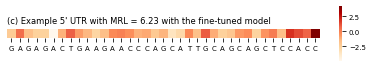

In [108]:
# for (i, s, l) in index_ccacc_high:
#     print(i, s, f'{l:.2f}')
i = 2743
s, l, a = seqs[i], labels[i], attns[i]
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
fig = plt.figure(figsize = (7, 10))

cmap = 'OrRd'
sns.heatmap(a.sum(axis = -1).reshape(-1, 1).T[:, -len(s):], cmap = cmap, cbar = False, square = True,
        xticklabels = s, yticklabels = '')

plt.title(f"(c) Example 5' UTR with MRL = {l:.2f} with the fine-tuned model", loc = 'left')
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = a.min().min(), vmax = a.max().max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                orientation='vertical', shrink = 0.1) # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)

plt.savefig(f'MRL{l:.2f}_finetuned.pdf')
plt.show()
#     break

/tmp/ipykernel_82922/4046189214.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap),


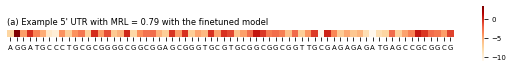

In [95]:
# draw_eachlength_head_pepposition(sum_peplength_pepposition, label, savepath = False)
fig = plt.figure(figsize = (10, 10))

cmap = 'OrRd'
sns.heatmap(attns_low.sum(axis = -1).reshape(-1, 1).T[:, -len(seqs_low[0]):], cmap = cmap, cbar = False, square = True,
        xticklabels = seqs_low[0], yticklabels = '')

plt.title(f"(a) Example 5' UTR with MRL = {labels_low[0]:.2f} with the finetuned model", loc = 'left')
plt.ylabel('')

norm = mpl.colors.Normalize(vmin = attns_low.min().min(), vmax = attns_low.max().max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), 
                orientation='vertical', shrink = 0.1) # , anchor = (-0.2, 0.5)
cbar.outline.set_visible(False)

plt.savefig('MRL0.79_finetuned.pdf')
plt.show()